Import Python packages.

In [1]:
import os
from pathlib import Path
import tifffile as tf
from IPython.display import Image, display

from gvxrPython3 import gvxr, json2gvxr
from gvxrPython3.gVXRDataReader import *

from cil.utilities.display import show_geometry
from cil.processors import TransmissionAbsorptionConverter
from cil.recon import FBP
from cil.utilities.jupyter import islicer

spekpy is not install, you won't be able to load a beam spectrum using spekpy
SimpleGVXR 2.0.6 (2023-05-23T15:10:16) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T15:10:15) [Compiler: GNU g++] on Linux


The working directory is not necessary the path of the Notebook on my Mac. The line below enables us to locate the path of the notebbok. This is useful to save output files.

In [2]:
current_folder = str(globals()['_dh'][0])

In [3]:
JSON_fname = current_folder + "/../JSON/W_fibres.json"
file_abs_path = os.path.abspath(JSON_fname)
dir_path = os.path.dirname(file_abs_path)

Import gVXR and create an OpenGL context. The code below works on Google Colab, GNU/Linux computers, Windows, and MacOS (only the Intel architecture was tested).

In [4]:
# Create an OpenGL context
# MS Windows
if os.name == "nt":
    json2gvxr.initGVXR(JSON_fname, "OPENGL")
# MacOS
elif str(os.uname()).find("Darwin") >= 0:
    json2gvxr.initGVXR(JSON_fname, "OPENGL")
else:
    json2gvxr.initGVXR(JSON_fname, "EGL")

Create an OpenGL context: 800x450


Wed Nov  1 15:31:13 2023 ---- Create window (ID: -1)
Wed Nov  1 15:31:13 2023 ---- Query the number of EGL devices
Wed Nov  1 15:31:13 2023 ---- Success
Wed Nov  1 15:31:13 2023 ---- Detected 3 EGL devices.
Wed Nov  1 15:31:13 2023 ---- Print the details here of every EGL device.
Wed Nov  1 15:31:13 2023 ---- Success
Wed Nov  1 15:31:13 2023 ---- Device 1/3:
Wed Nov  1 15:31:13 2023 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Wed Nov  1 15:31:13 2023 ---- Device 2/3:
Wed Nov  1 15:31:13 2023 ---- 	Device Extensions: EGL_EXT_device_drm EGL_EXT_device_drm_render_node
Wed Nov  1 15:31:13 2023 ---- Device 3/3:
Wed Nov  1 15:31:13 2023 ---- 	Device Extensions: EGL_MESA_device_software EGL_EXT_device_drm_render_node
Wed Nov  1 15:31:13 2023 ---- EGL client extensions: EGL_EXT_platform_base EGL_EXT_device_base EGL_EXT_device_enumeration EGL_EXT_device_query EGL_KHR_client_get_all_proc_addr

Initialise the simulation

In [5]:
json2gvxr.initDetector()
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum()
json2gvxr.initSamples()
json2gvxr.initScan()

Set up the detector
	Detector position: [0, 80, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [1217, 320]
	Detector number of pixels: [1217, 320]
	Pixel spacing: [1.9, 1.9, 'um']
Set up the beam
	Source position: [0, -144.92, 0, 'mm']
	Source shape: Parallel
Set up the CT Scan


Wed Nov  1 15:31:13 2023 ---- Initialise the renderer
Wed Nov  1 15:31:14 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/W_fibres/final_W_cores.stl	nb_faces:	24000	nb_vertices:	72000	bounding_box (in cm):	(-0.0478145, -0.04075, -0.0723245)	(0.0462945, 0.04075, 0.0689045)
Wed Nov  1 15:31:14 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/W_fibres/final_SiC_fibres.stl	nb_faces:	48000	nb_vertices:	144000	bounding_box (in cm):	(-0.0523952, -0.04075, -0.0769052)	(0.0508752, 0.04075, 0.0734852)
Wed Nov  1 15:31:14 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/W_fibres/final_Ti90Al6V4_matrix.stl	nb_faces:	24012	nb_vertices:	72036	bounding_box (in cm):	(-0.0598798, -0.04075, -0.0769052)	(0.0508752, 0.04075, 0.0734852)


Run the CT acquisition data simualtion

In [6]:
angles = json2gvxr.doCTScan(verbose=False)

In [7]:
# Get the path where the projections are
output_path = json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"])

In [8]:
# Save angles to file
with open(output_path + "/angles.csv", "w") as f:
    f.writelines([ f"{x}\n" for x in angles])

Display an animation

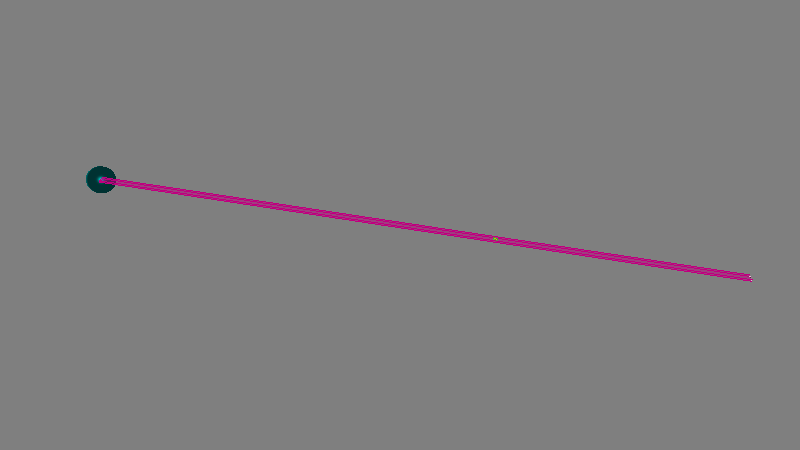

In [9]:
with open(json2gvxr.getFilePath(json2gvxr.params["Scan"]["GifPath"]),'rb') as f:
    display(Image(data=f.read(), format='png', width=1000))

Load the projection data into CIL

In [10]:
reader = gVXRDataReader(file_name=output_path, angle_set=angles)
data = reader.read()
gvxr.terminate()

[ 0. -1.  0.]
[ -0. -80.  -0.]
[0, 0, 0]
(0.0, 0.0, -1.0)
[1217  320]
[0.0018999999727297731, 0.0018999999727297731]


Wed Nov  1 15:32:37 2023 ---- Destroy all the windows
Wed Nov  1 15:32:37 2023 ---- Destroy window 0(0x5648f3c51ae0)


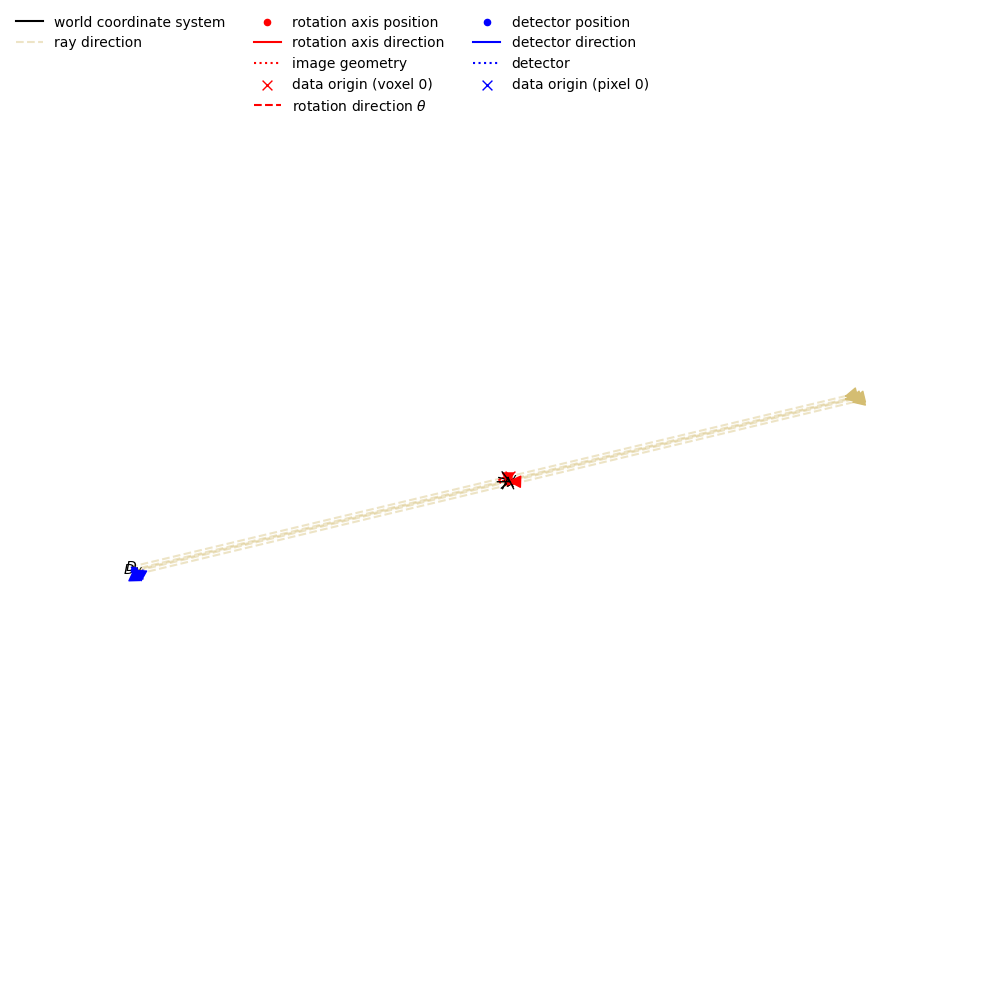

In [11]:
show_geometry(data.geometry)

In [12]:
data.reorder(order='tigre')
data_corr = TransmissionAbsorptionConverter(white_level=data.max())(data)

Launch the CT reconstruction

In [13]:
ig = data.geometry.get_ImageGeometry()

ig.voxel_num_x = 600
ig.voxel_num_y = 600
ig.voxel_num_z = 700

reco1 = FBP(data_corr, ig).run()

FBP recon

Input Data:
	angle: 360
	vertical: 320
	horizontal: 1217

Reconstruction Volume:
	vertical: 700
	horizontal_y: 600
	horizontal_x: 600

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



Visualise the results

In [14]:
islicer(reco1, direction='vertical')

In [15]:
islicer(reco1, direction='horizontal_x')